In [1]:
# DataFrame
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

Using TensorFlow backend.


In [3]:
#https://www.kaggle.com/kazanova/sentiment140

In [2]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Arlen\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
# DATASET
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8

# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 8
BATCH_SIZE = 1024

# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

# EXPORT
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"

Dataset details
target: the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)

ids: The id of the tweet ( 2087)

date: the date of the tweet (Sat May 16 23:58:44 UTC 2009)

flag: The query (lyx). If there is no query, then this value is NO_QUERY.

user: the user that tweeted (robotickilldozr)

text: the text of the tweet (Lyx is cool)


In [4]:
df = pd.read_csv("resources/training.1600000.processed.noemoticon.csv", encoding =DATASET_ENCODING , names=DATASET_COLUMNS)
df_original=df.copy()

In [5]:
print("Dataset size:", len(df))

Dataset size: 1600000


In [6]:
df.head(5)

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [7]:
#Map target label to String
#0 -> NEGATIVE
#2 -> NEUTRAL
#4 -> POSITIVE
decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]

In [8]:
%%time
df.target = df.target.apply(lambda x: decode_sentiment(x))

Wall time: 439 ms


In [9]:
df.head(5)

,target,ids,date,flag,user,text
0,NEGATIVE,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,NEGATIVE,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,NEGATIVE,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,NEGATIVE,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,NEGATIVE,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


Text(0.5, 1.0, 'Dataset labels distribuition')

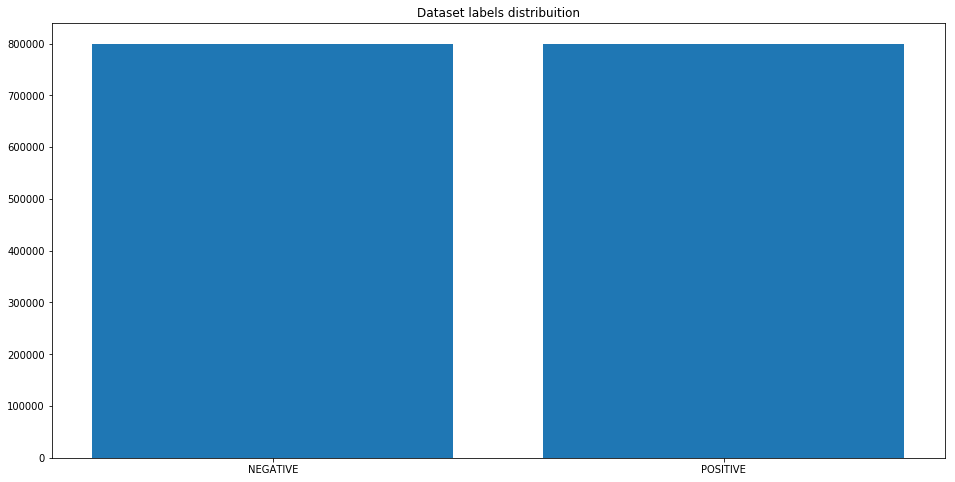

In [10]:
target_cnt = Counter(df.target)

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

In [11]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

In [12]:
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [13]:
%%time
df.text = df.text.apply(lambda x: preprocess(x))

Wall time: 39.6 s


In [14]:
print(df_original.loc[7].text)
print('\n\n\n')
print(df.loc[7].text)

@LOLTrish hey  long time no see! Yes.. Rains a bit ,only a bit  LOL , I'm fine thanks , how's you ?




hey long time see yes rains bit bit lol fine thanks


In [15]:
df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 1280000
TEST size: 320000


In [26]:
df_train.head()

,target,ids,date,flag,user,text
1374558,POSITIVE,2051457557,Fri Jun 05 22:04:23 PDT 2009,NO_QUERY,JGoldsborough,ya quot like palm pre touchstone charger ready...
1389115,POSITIVE,2053083567,Sat Jun 06 03:12:21 PDT 2009,NO_QUERY,Psioui,felt earthquake afternoon seems epicenter
1137831,POSITIVE,1976779404,Sat May 30 19:02:49 PDT 2009,NO_QUERY,adriville,ruffles shirts like likey
790714,NEGATIVE,2325739990,Thu Jun 25 05:59:18 PDT 2009,NO_QUERY,Blondie128,pretty bad night crappy morning fml buttface d...
1117911,POSITIVE,1973503391,Sat May 30 11:16:35 PDT 2009,NO_QUERY,khrabrov,yeah clear view


In [16]:
#Word2Vec
#documents = [_text.split() for _text in df_train.text] 

In [81]:
#w2v_model = gensim.models.word2vec.Word2Vec(size=W2V_SIZE, 
#                                           window=W2V_WINDOW, 
#                                            min_count=W2V_MIN_COUNT, 
#                                            workers=8)

In [82]:
#w2v_model.build_vocab(documents)

In [37]:
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 30369


In [51]:
print(w2v_model['love'])

[-0.6092815  -1.3770176   0.37928241 -0.0928444   0.38550758  0.05315144
 -0.33285102 -1.3047546  -0.60536253 -0.8437261   0.07927196  0.84377486
  1.0677129  -0.16902217  0.84502655 -0.6592212   0.14326225  0.7607816
 -0.6902154  -0.43610168  0.71602213 -0.14570644  0.9824015  -0.12701796
 -0.07124592  0.9208226   0.53180003 -0.20232889 -0.61431146  0.2699591
 -0.19721615  0.3814359   0.31324103 -0.06227986  1.7593611  -0.9569354
  0.75991625 -1.3987637  -0.9275163  -0.0772289  -0.20566289 -0.45391184
  0.68326855  0.4404297   0.93214446 -0.5042386   0.8030717   0.562305
  1.0543078  -0.7883     -0.46903047  0.47079915  0.24247585  1.5667266
 -0.87440634  1.3467447  -0.03522951 -0.27857408  1.2909738   0.09354103
 -0.07509222 -0.12363411 -0.65170974  0.18596508  0.62308776  1.0527385
 -1.1228355   0.33718356 -1.494151   -0.7471534   0.33039612 -0.2520788
 -0.7279775  -1.4693387  -0.20819843  1.0787331   0.31559733  0.39179897
  0.19236195 -0.60526824  1.9832449   1.4412109   1.7020094

C:\Users\Arlen\AppData\Local\Continuum\anaconda3\envs\pythondata\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


In [48]:
w2v_model.wv.vocab['good']

In [ ]:
%%time
#w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

In [17]:
from gensim.models import Word2Vec
w2v_model = Word2Vec.load('resources/model.w2v')

In [18]:
w2v_model.most_similar("love")


C:\Users\Arlen\AppData\Local\Continuum\anaconda3\envs\pythondata\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('luv', 0.5732780694961548),
 ('loves', 0.5623787045478821),
 ('loved', 0.5373271703720093),
 ('amazing', 0.5026600360870361),
 ('adore', 0.4942743480205536),
 ('looove', 0.47235167026519775),
 ('awesome', 0.4598265290260315),
 ('lovee', 0.45823752880096436),
 ('loveee', 0.4531649351119995),
 ('loooove', 0.44260522723197937)]

In [49]:
print(w2v_model)

Word2Vec(vocab=30369, size=300, alpha=0.025)


In [27]:
#Tokenize Text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 290419


In [34]:
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=SEQUENCE_LENGTH)


array([[     0,      0,      0, ...,    712,    118,  24590],
       [     0,      0,      0, ...,    452,    378,  32447],
       [     0,      0,      0, ...,   2048,      4,   5487],
       ...,
       [     0,      0,      0, ...,    661,   4246, 290416],
       [     0,      0,      0, ...,     12,    477,    957],
       [     0,      0,      0, ...,      9,    502,    268]])

In [35]:
type(x_train)

numpy.ndarray

In [20]:
#Label Encoder
labels = df_train.target.unique().tolist()
labels.append(NEUTRAL)
labels

['POSITIVE', 'NEGATIVE', 'NEUTRAL']

In [21]:
encoder = LabelEncoder()
encoder.fit(df_train.target.tolist())

y_train = encoder.transform(df_train.target.tolist())
y_test = encoder.transform(df_test.target.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (1280000, 1)
y_test (320000, 1)


In [22]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(290419, 300)


In [23]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (1280000, 300)
y_train (1280000, 1)

x_test (320000, 300)
y_test (320000, 1)


In [39]:
#embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

In [40]:
#Build Model

#model = Sequential()
#model.add(embedding_layer)
#model.add(Dropout(0.5))
#model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
#model.add(Dense(1, activation='sigmoid'))


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [41]:
#model.compile(loss='binary_crossentropy',
#              optimizer="adam",
#              metrics=['accuracy'])

In [42]:
#callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
#              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

In [ ]:
#%%time
#history = model.fit(x_train, y_train,
#                    batch_size=BATCH_SIZE,
#                    epochs=EPOCHS,
#                    validation_split=0.1,
#                    verbose=1,
#                    callbacks=callbacks)

Instructions for updating:
Use tf.cast instead.
Train on 1152000 samples, validate on 128000 samples
Epoch 1/8
   7168/1152000 [..............................] - ETA: 6:55:04 - loss: 0.6726 - acc: 0.5758

In [24]:
from keras.models import load_model
model = load_model('resources/sentiment_model.h5')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


In [25]:
import pickle
tokenizer = Tokenizer()
with open('resources/tokenizer.pkl', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [ ]:
#score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
#print()
#print("ACCURACY:",score[1])
#print("LOSS:",score[0])

  6144/320000 [..............................] - ETA: 26:05

In [26]:
def decode_sentiment(score, include_neutral=True):
    if include_neutral:        
        label = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = POSITIVE

        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE

In [27]:
def predict(text, include_neutral=True):
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=300)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)
    return {"label": label, "score": float(score)} 

In [28]:
predict("I love the music")

{'label': 'POSITIVE', 'score': 0.9656286239624023}

In [29]:
predict("I hate the rain")

{'label': 'NEGATIVE', 'score': 0.010753682814538479}